### RankNet-makedb-laptime

build laptime dataset from raw log files

base: 18./laptime_rank_timediff_dataset

create laptime dataset only, no gluonts.

+ add lap2nextpit as target, this is as the same as a stacked lstm model when set prediction_length=1
+ add lap_instint to dynamic features(pitage)
+ add support for historical data, indy500 for different years
+ add track and lap status as target, preparing for StatusModel with deepAR

this notebook focuses on create the training set, while laptime2rank-evaluate will have testset codes specified for rank calculation

+ add new features, caution_laps_instint,lap_instint

Build a time series dataset across all the oval races, including laptime, rank. When this dataset aims to be used in forecasting, covariates of the racing status can not be included, such as track_status and lap_status. However, they can be used in oracle test to tell the upper bound of performance of the predictor.

Change to a new dataset format that following telemetry dataset.

raw:
+  [(eventid, carids: carno -> rowid, datalist)]

datalist := [datalist_entry] in shape of #car_number

datalist_entry := [[laptime, rank, track_status, lap_status]], in shape of #totallaps x #featureCnt (padded by nan)

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters

import indycar.model.global_variables as gvar
from indycar.model.quicktest_modules import *

register_matplotlib_converters()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [10]:
outputRoot = 'test/'
stagedata = {}
global_carids = {}
traindata = None
cur_carid = 0

#inlap status = 
# 0 , no inlap
# 1 , set previous lap
# 2 , set the next lap
_inlap_status = 0
_featureCnt = 9
#
# input data parameters
#
#events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
#events_totalmiles=[256,500,372,268,500,310]
#events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events_info = {
    'Phoenix':(256, 1.022),'Indy500':(500,2.5),'Texas':(372,1.5),
    'Iowa':(268,0.894),'Pocono':(500,2.5),'Gateway':(310,1.25)
}

years = ['2013','2014','2015','2016','2017','2018','2019']
events = [f'Indy500-{x}' for x in years]

events.extend(['Phoenix-2018','Texas-2018','Texas-2019','Pocono-2018','Pocono-2019','Iowa-2018','Iowa-2019',
              'Gateway-2018','Gateway-2019'])

events_id={key:idx for idx, key in enumerate(events)}

#version = f'IndyCar-d{len(events)}'

#dbid = f'Indy500_{years[0]}_{years[-1]}_v{_featureCnt}_p{_inlap_status}'
dbid = f'IndyCar_d{len(events)}_v{_featureCnt}_p{_inlap_status}'

LAPTIME_DATASET = f'{outputRoot}/laptime_rank_timediff_pit-oracle-{dbid}.pickle' 
STAGE_DATASET = f'{outputRoot}/stagedata-{dbid}.pickle' 

_test_event = 'Phoenix-2018'

In [11]:
gvar.events = events
gvar.events_id  = events_id
gvar.events_info = events_info


gvar.maxlap = get_event_info(_test_event)[0]
gvar.dbid = dbid
gvar.LAPTIME_DATASET = LAPTIME_DATASET

In [12]:
for event in events:
    #dataid = f'{event}-{year}'
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event)

    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))

    #build the carid map
    for car in carlist:
        if car not in global_carids:
            global_carids[car] = cur_carid
            cur_carid += 1


count of completed cars: 19
completed cars: [11 26  1 25 19  3  2 77 83 20 22  8 14  9 18 55 78  5 12]
cars: {1, 2, 3, 5, 8, 9, 11, 12, 77, 14, 78, 18, 19, 20, 83, 22, 55, 25, 26}
#cars= 19
count of completed cars: 19
completed cars: [11 26  1 25 19  3  2 77 83 20 22  8 14  9 18 55 78  5 12]
cars: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 25, 26, 27, 41, 55, 60, 63, 77, 78, 81, 83, 91, 98}
#cars= 33
Indy500-2013: carno=33, lapnum=201
count of completed cars: 20
completed cars: [28  3 25 34  2 26 11 12 22 21 16 77 68  5 17 33 18  8 14 98]
cars: {33, 2, 3, 34, 5, 68, 98, 8, 11, 12, 77, 14, 16, 17, 18, 21, 22, 25, 26, 28}
#cars= 20
count of completed cars: 20
completed cars: [28  3 25 34  2 26 11 12 22 21 16 77 68  5 17 33 18  8 14 98]
cars: {2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 33, 34, 41, 63, 67, 68, 77, 83, 91, 98}
#cars= 33
Indy500-2014: carno=33, lapnum=201
count of completed cars: 20
completed cars: [ 2  1

Iowa-2018: carno=22, lapnum=301
count of completed cars: 7
completed cars: [ 2  9  5 22 21 27 26]
cars: {2, 5, 9, 21, 22, 26, 27}
#cars= 7
count of completed cars: 7
completed cars: [ 2  9  5 22 21 27 26]
cars: {2, 4, 5, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 26, 27, 28, 30, 31, 59, 88, 98}
#cars= 22
Iowa-2019: carno=22, lapnum=301
count of completed cars: 8
completed cars: [12 27  9 22 26 21  1 10]
cars: {1, 9, 10, 12, 21, 22, 26, 27}
#cars= 8
count of completed cars: 8
completed cars: [12 27  9 22 26 21  1 10]
cars: {1, 4, 5, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
#cars= 21
Gateway-2018: carno=21, lapnum=249
count of completed cars: 11
completed cars: [30 20 14 19 22 59  2 28 88 98 10]
cars: {2, 98, 10, 14, 19, 20, 22, 88, 59, 28, 30}
#cars= 11
count of completed cars: 11
completed cars: [30 20 14 19 22 59  2 28 88 98 10]
cars: {2, 4, 5, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
#cars= 22
Gateway-2019: carno=22, lapnu

In [13]:
laptime_data = get_laptime_dataset(stagedata,inlap_status = _inlap_status)

start event: Indy500-2013
event=Indy500-2013, records=(33, 9, 200)
start event: Indy500-2014
event=Indy500-2014, records=(33, 9, 200)
start event: Indy500-2015
event=Indy500-2015, records=(33, 9, 200)
start event: Indy500-2016
event=Indy500-2016, records=(33, 9, 200)
start event: Indy500-2017
event=Indy500-2017, records=(33, 9, 200)
start event: Indy500-2018
event=Indy500-2018, records=(33, 9, 200)
start event: Indy500-2019
event=Indy500-2019, records=(33, 9, 200)
start event: Phoenix-2018
event=Phoenix-2018, records=(23, 9, 250)
start event: Texas-2018
event=Texas-2018, records=(22, 9, 248)
start event: Texas-2019
event=Texas-2019, records=(22, 9, 248)
start event: Pocono-2018
event=Pocono-2018, records=(22, 9, 200)
start event: Pocono-2019
event=Pocono-2019, records=(22, 9, 128)
start event: Iowa-2018
event=Iowa-2018, records=(22, 9, 300)
start event: Iowa-2019
event=Iowa-2019, records=(22, 9, 300)
start event: Gateway-2018
event=Gateway-2018, records=(21, 9, 248)
start event: Gatewa

In [6]:
import pickle
#stintdf.to_csv('laptime-%s.csv'%year)
savefile = LAPTIME_DATASET
print(savefile)
with open(savefile, 'wb') as f:
    #pack [global_carids, laptime_data]
    savedata = [global_carids, laptime_data]
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

test//laptime_rank_timediff_pit-oracle-IndyCar_d16_v9_p0.pickle


In [7]:
savefile = STAGE_DATASET 
print(savefile)
with open(savefile, 'wb') as f:
    #pack [global_carids, laptime_data]
    savedata = stagedata
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

test//stagedata-IndyCar_d16_v9_p0.pickle


### test

In [8]:
sys.exit(0)

SystemExit: 0

/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
lapstatusA = laptime_data[-1][2][1,3,:]
#lapstatusA = laptime_data[-1][2][0,3,:]
lapstatusA

In [ ]:
lap2nextpit = laptime_data[-1][2][1,8,:]
#lap2nextpit = laptime_data[-1][2][0,8,:]
lap2nextpit

In [ ]:
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [ ]:
def test_a(a, bitflag):
    return (a & bitflag) ==  bitflag

test_a(5, 4)


In [ ]:
mat = np.random.randint(5, size=(10,2, 5)).astype(np.float)
mat[2,1,0] = np.nan
_idx = np.array([0,1,2,8])
selmat = mat[_idx]
selmat[:,1,:]

In [ ]:
mask = np.isnan(selmat[:,1,:])
mask

In [ ]:
true_rank.shape

In [ ]:
idx = np.argsort(selmat[:,1,:], axis=0)
true_rank = np.argsort(idx, axis=0).astype(np.float)
true_rank[mask] = np.nan
true_rank

In [ ]:
selmat[:,1,:] = true_rank
selmat

In [ ]:
mat[_idx]

In [ ]:
mat[_idx] = selmat

In [ ]:
mat[_idx]

In [ ]:
freq, prediction_length, cardinality = 0,0,0

def load_dataset(inputfile):
    global freq, prediction_length, cardinality

    with open(inputfile, 'rb') as f:
        # have to specify it.
        freq, prediction_length, cardinality,train_ds, test_ds = pickle.load(f, encoding='latin1')
    
    print(f"number of cars: {cardinality}")
    
    return train_ds, test_ds

train_ds, test_ds = load_dataset('rank-oracle-noip-eid-all-all-f1min-t30-rIndy500-gluonts-indy-2018.pickle')

In [ ]:
ds_iter =  iter(test_ds)
rec = next(ds_iter)
rec

In [ ]:
def debug_get_ranklist(train_ds):
    ds_iter =  iter(train_ds)
    ranklist = []
    for idx in range(len(train_ds)):
        rec = next(ds_iter)

        if rec['feat_static_cat'][1] == 0:
            ranklist.append(rec['target'][0])

    return np.array(sorted(ranklist))

In [ ]:
len(ranklist)

In [ ]:
rank_train, rank_ds = get_testds(True)

In [ ]:
rawrank_train, rawrank_ds = get_testds(False)

In [ ]:
debug_get_ranklist(rank_train)

In [ ]:
debug_get_ranklist(rawrank_train)

In [ ]:
debug_get_ranklist(train_ds)

In [ ]:
 #alldata, rankdata, acldata, flagdata = stagedata['Indy500-2011']

In [ ]:
set(acldata.car_number.values)

In [ ]:
acldata

In [ ]:
acldata[acldata['completed_laps']==187]

In [ ]:
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==186].car_number.values))))
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==187].car_number.values))))
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==188].car_number.values))))
print(','.join(list(sorted(rankdata[rankdata['completed_laps']==189].car_number.values))))


In [ ]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2014']

In [ ]:
kannan = rankdata[rankdata['car_number']==10]
kannan[(kannan['completed_laps'] > 60) & (kannan['completed_laps']<70)]

In [ ]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2013']
rankdata[(rankdata['car_number']==16) & (rankdata['completed_laps']<10)]

In [ ]:
rankdata[(rankdata['car_number']==16) & (rankdata['completed_laps']>88)& (rankdata['completed_laps']<97)]

In [ ]:
car16 = acldata[acldata['car_number']==16]


In [ ]:
for idx in range(len(car16)):
    if(car16.iloc[idx].lap_status == 'P'):
        print(car16.iloc[idx].completed_laps)

In [ ]:
for idx in range(len(car16)):
    if(car16.iloc[idx].track_status == 'Y'):
        print(car16.iloc[idx].completed_laps)

In [ ]:
### check the inlap
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']
car12 = acldata[acldata['car_number']==12]
for idx in range(len(car12)):
    if(car12.iloc[idx].lap_status == 'P'):
        print(car12.iloc[idx].completed_laps)

In [ ]:
rankdata[(rankdata['car_number']==12)]

In [ ]:
pitlap = 94
rankdata[(rankdata['car_number']==12) & (rankdata['completed_laps']>=pitlap -2) & ((rankdata['completed_laps']<=pitlap+2))]

In [ ]:
pitlap = 50
rankdata[(rankdata['car_number']==12) & (rankdata['completed_laps']>=pitlap -2) & ((rankdata['completed_laps']<=pitlap+2))]

In [ ]:
pitlap = 94
rankdata[(rankdata['car_number']==12) & (rankdata['completed_laps']>=pitlap -2) & ((rankdata['completed_laps']<=pitlap+2))]

In [ ]:
rankdata[(rankdata['completed_laps']==200)]

In [ ]:
rankdata[(rankdata['completed_laps']==0)]

In [ ]:
### top cars
top10 = rankdata[(rankdata['completed_laps']==200) & (rankdata['rank']<10)]
list(top10.car_number)

In [ ]:
### show the data
dfx = rankdata
dfx.info()

In [ ]:
dfx = rankdata[['rank','car_number','completed_laps','last_laptime','time_behind_leader','lap_status','track_status']]
#dfx.drop('index')
dfx[(dfx['completed_laps']>30) & (dfx['completed_laps']<50)]

### draw timeline

In [ ]:
### draw timeline
df12 = rankdata[rankdata['car_number']==12]
df12

In [ ]:
df12[df12['lap_status']=='P']

In [ ]:
df12[df12['completed_laps'].isin([30,31,32,33,34])]

In [ ]:
data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
pitstop = df12[['lap_status']].values
caution = df12[['track_status']].values
pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
caution = np.array([1 if x=='Y' else 0 for x in caution])
pitidx = np.where(pitstop == 1)
pits = data[pitidx]
yidx = np.where(caution == 1)
cautions = data[yidx]

In [ ]:
np.sum(caution)

In [ ]:
np.sum(pitstop)

In [ ]:
data.shape

In [ ]:
pitidx = np.where(pitstop == 1)
pits = data[pitidx]


In [ ]:
yidx = np.where(caution == 1)
cautions = data[yidx]

In [ ]:
pits

In [ ]:
plt.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 7))
axs[0].plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs[0].plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)

axs[1].plot(data[:,0],data[:,2],'.-',label='LapTime', linewidth=2)
axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
axs[1].plot(pits[:,0],pits[:,2],'+',color='r', label='PitStop', linewidth=2)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 7))
axs.plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
axs.plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs.plot(pits[:,0],pits[:,1],'+',color='r', label='PitStop', linewidth=2)

for lap in range(200):
    fc = 'green'
    if caution[lap] == 1:
        fc = 'yellow'
    if pitstop[lap] == 1:
        fc = 'red'
    ec = fc
    rectangle = plt.Rectangle((lap,0), 1, 1, fc=fc,ec=ec)
    #plt.gca().add_patch(rectangle)
    axs.add_patch(rectangle)


In [ ]:
red = ''#ff8080'
yellow = '#8080ff'
green = '#80ff80'

def add_status(axs):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,-1), 1, 1, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

fig, axs = plt.subplots(2, 1, figsize=(20, 7))
axs[0].plot(data[:,0],data[:,1],'.-',label='RANK', linewidth=2)
#axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs[0].plot(pits[:,0],pits[:,1],'^',color='r', label='PitStop', linewidth=2)
for lap in range(200):
    fc = 'green'
    if caution[lap] == 1:
        fc = 'yellow'
    if pitstop[lap] == 1:
        fc = 'red'
    ec = fc
    rectangle = plt.Rectangle((lap,-1), 1, 1, fc=fc,ec=ec)
    #plt.gca().add_patch(rectangle)
    axs[0].add_patch(rectangle)
axs[0].set_ylim((-1,17.5))
axs[0].set_ylabel('Rank')

axs[1].plot(data[:,0],data[:,2],'.-',label='LapTime', linewidth=2)
#axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
axs[1].plot(pits[:,0],pits[:,2],'^',color='r', label='PitStop', linewidth=2)
for lap in range(200):
    fc = 'green'
    if caution[lap] == 1:
        fc = 'yellow'
    if pitstop[lap] == 1:
        fc = 'red'
    ec = fc
    rectangle = plt.Rectangle((lap,35), 1, 4, fc=fc,ec=ec)
    #plt.gca().add_patch(rectangle)
    axs[1].add_patch(rectangle)
axs[1].set_ylim((35,120))    

axs[1].set_ylabel('LapTime(s)')
axs[1].set_xlabel('Lap')

In [ ]:
data = data[1:,:]
#pits = pits[1:]


In [ ]:

#red = '#ff8080'
red = 'red'
#yellow = '#8080ff'
yellow = 'yellow'
#green = '#80ff80'
green = 'green'

def add_status(axs,y=-1, height=1):
    for lap in range(200):
        fc = green
        if caution[lap] == 1:
            fc = yellow
        if pitstop[lap] == 1:
            fc = red
        ec = fc
        rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
        #plt.gca().add_patch(rectangle)
        axs.add_patch(rectangle)

lw=2
        
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
axs[0].plot(data[:,0],data[:,1],'.-', linewidth=lw)
#axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
axs[0].plot(pits[:,0],pits[:,1],'^',color='r', label='PitStop', linewidth=lw)
add_status(axs[0])
axs[0].set_ylim((-1,19))
axs[0].set_ylabel('Rank')

axs[1].plot(data[:,0],data[:,2],'.-', linewidth=lw)
#axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
axs[1].plot(pits[:,0],pits[:,2],'^',color='r', label='PitStop', linewidth=lw)
add_status(axs[1],33,4)
axs[1].set_ylim((33,120))    

axs[1].set_ylabel('LapTime(s)')
axs[1].set_xlabel('Lap')

axs[1].plot([0],[0],'s',color=green, label='NoramlLap', linewidth=lw)
axs[1].plot([0],[0],'s',color=yellow, label='CautionLap', linewidth=lw)
plt.legend(prop={'size': 10})
plt.savefig('laptime_rank.pdf')

In [ ]:
plt.savefig('laptime_rank.pdf')

In [ ]:
savedata('Fig2-b.pickle',[data, pits, caution, pitstop])

## rank change distribution

pits

In [ ]:
rankdata.completed_laps.values

In [57]:
#low, high = 0, 1
low, high = 1, 1

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


In [58]:
### check the rank change


alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']


carlist = set(list(rankdata.car_number.values))

rankchg_df = []
rankchg_cols = ['carno', 'normalpit', 'rankchange']
for carno in carlist:
    df = rankdata[rankdata['car_number']==carno]
    
    pits = df[df['lap_status']=='P']
    
    for pitlap in pits.completed_laps.values:
        pitdf = df[(df['completed_laps']>=pitlap-low) & (df['completed_laps']<=pitlap+high)]
        
        rankchange = np.max(pitdf[['rank']].values) - np.min(pitdf[['rank']].values)
        
        trackstatus = df[df['completed_laps']==pitlap].track_status.values[0]
        normalpit = 0 if trackstatus == 'Y' else 1
                          
        rankchg_df.append([carno, normalpit, rankchange])
                          
rankchg_df = pd.DataFrame(data=rankchg_df, columns=rankchg_cols)        

In [59]:
print('normalpit .vs. cautionpit:', len(rankchg_df[rankchg_df['normalpit']==1]), len(rankchg_df[rankchg_df['normalpit']==0]))

normalpit .vs. cautionpit: 115 77


In [60]:
print('min:', np.min(rankchg_df.rankchange.values),np.max(rankchg_df.rankchange.values))

min: 0 28


In [61]:
rankchg_df.head(10)

,carno,normalpit,rankchange
0,1,1,12
1,1,0,2
2,1,0,17
3,1,1,19
4,1,1,19
5,1,1,10
6,3,1,16
7,3,0,4
8,3,1,17
9,3,1,14


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


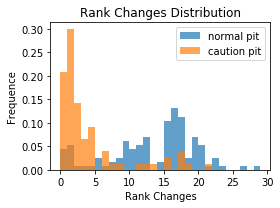

In [62]:
# car 12, will power
bins=np.arange(30)
cautionpits = rankchg_df[rankchg_df['normalpit']==0].rankchange
normalpits = rankchg_df[(rankchg_df['normalpit']==1)].rankchange

fig, axs = plt.subplots(1, 1, figsize=(4, 3))
axs.hist(normalpits,bins= bins,normed=1,  alpha=0.7,label='normal pit')
axs.hist(cautionpits,bins= bins,normed=1,  alpha=0.7,label='caution pit')
axs.set_xlabel('Rank Changes')
axs.set_ylabel('Frequence')
axs.set_title('Rank Changes Distribution')
axs.legend(prop={'size': 10})
plt.tight_layout()
plt.savefig('rankchange_distribution-%d%d.pdf'%(low, high))

In [ ]:
import pickle
def savedata(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
df12[df12['track_status']=='Y'].completed_laps.values

In [ ]:
df12[df12['lap_status']=='P'].completed_laps.values

## Get pit-covered-laps

In [52]:
### check the inlap
covergap = 1
pitdata = {}
for event in events:    
    alldata, rankdata, acldata, flagdata = stagedata[event]

    totallaps = np.max(rankdata.completed_laps.to_numpy())
    #pitlaps = rankdata[rankdata['lap_status']=='P'][['completed_laps']].to_numpy()
    pitlaps = rankdata[rankdata['lap_status']=='P'].completed_laps.to_numpy()

    pitlaps = set(sorted(pitlaps))

    pitcoveredlaps = []
    for lap in pitlaps:
        gap = range(lap - covergap, lap + covergap+1)
        #pitcoveredlaps.extend([lap -2,lap-1,lap,lap+1,lap+2])
        pitcoveredlaps.extend(gap)

    pitcoveredlaps = set(sorted(pitcoveredlaps))
    
    print(event, 'total:', totallaps, 'pitlaps:', len(pitlaps), 'pitcoveredlaps:', len(pitcoveredlaps))
    
    #save
    pitdata[event] = [pitlaps, pitcoveredlaps]

Indy500-2013 total: 200 pitlaps: 70 pitcoveredlaps: 119
Indy500-2014 total: 200 pitlaps: 75 pitcoveredlaps: 126
Indy500-2015 total: 200 pitlaps: 48 pitcoveredlaps: 80
Indy500-2016 total: 200 pitlaps: 70 pitcoveredlaps: 120
Indy500-2017 total: 200 pitlaps: 70 pitcoveredlaps: 124
Indy500-2018 total: 200 pitlaps: 76 pitcoveredlaps: 122
Indy500-2019 total: 200 pitlaps: 74 pitcoveredlaps: 102
Phoenix-2018 total: 250 pitlaps: 42 pitcoveredlaps: 70
Texas-2018 total: 248 pitlaps: 53 pitcoveredlaps: 112
Texas-2019 total: 248 pitlaps: 49 pitcoveredlaps: 84
Pocono-2018 total: 200 pitlaps: 47 pitcoveredlaps: 79
Pocono-2019 total: 128 pitlaps: 42 pitcoveredlaps: 72
Iowa-2018 total: 300 pitlaps: 49 pitcoveredlaps: 103
Iowa-2019 total: 300 pitlaps: 40 pitcoveredlaps: 78
Gateway-2018 total: 248 pitlaps: 48 pitcoveredlaps: 97
Gateway-2019 total: 248 pitlaps: 53 pitcoveredlaps: 96


In [53]:
print('pitlaps:', len(pitdata[_test_event][0]), 'coveredlaps:', len(pitdata[_test_event][1]))

pitlaps: 42 coveredlaps: 70


In [54]:
import pickle
#stintdf.to_csv('laptime-%s.csv'%year)
savefile = f'pitcoveredlaps-alldata-g{covergap}.pickle' 
print(savefile)
with open(savefile, 'wb') as f:
    #pack [global_carids, laptime_data]
    savedata = pitdata
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

pitcoveredlaps-alldata-g1.pickle


## check df12

In [ ]:
alldata, rankdata, acldata, flagdata = stagedata['Indy500-2018']
df12 = rankdata[rankdata['car_number']==12]

In [ ]:
df12[df12['completed_laps']>190]

In [ ]:
df3 = rankdata[rankdata['car_number']==12]
df3[(df3['completed_laps']>25) & (df3['completed_laps']<35)]

## draw 

In [43]:
def drawacar(test_event, carno=12):
    alldata, rankdata, acldata, flagdata = stagedata[test_event]
    
    #maxlap = get_event_info(test_event)[0]
    print('carno:', set(list(rankdata['car_number'].values)))
    print('laps:', set(list(rankdata['completed_laps'].values)))
    
    
    maxlap = max(list(rankdata['completed_laps'].values))
    
    a = rankdata[rankdata['completed_laps']>=maxlap-1]
    print(set(list(a['car_number'].values)))
    
    df12 = rankdata[rankdata['car_number']==carno]

    data = df12[['completed_laps','rank','last_laptime','time_behind_leader']].values
    pitstop = df12[['lap_status']].values
    caution = df12[['track_status']].values
    pitstop = np.array([1 if x=='P' else 0 for x in pitstop])
    caution = np.array([1 if x=='Y' else 0 for x in caution])
    pitidx = np.where(pitstop == 1)
    pits = data[pitidx]
    yidx = np.where(caution == 1)
    cautions = data[yidx]
    

    data = data[1:,:]
    
    #red = '#ff8080'
    red = 'red'
    #yellow = '#8080ff'
    yellow = 'yellow'
    #green = '#80ff80'
    green = 'green'
    
    
    print('maxlap:', maxlap)
    def add_status(axs,y=-1, height=1):
        for lap in range(maxlap):
            fc = green
            if caution[lap] == 1:
                fc = yellow
            if pitstop[lap] == 1:
                fc = red
            ec = fc
            rectangle = plt.Rectangle((lap,y), 1, height, fc=fc,ec=ec)
            #plt.gca().add_patch(rectangle)
            axs.add_patch(rectangle)

    lw=2

    fig, axs = plt.subplots(2, 1, figsize=(10, 4))
    axs[0].plot(data[:,0],data[:,1],'.-', linewidth=lw)
    #axs[0].plot(cautions[:,0],cautions[:,1],'.',color='y', label='CautionLap', linewidth=2)
    axs[0].plot(pits[:,0],pits[:,1],'^',color='r', label='PitStop', linewidth=lw)
    add_status(axs[0])
    axs[0].set_ylim((-1,19))
    axs[0].set_ylabel('Rank')

    axs[1].plot(data[:,0],data[:,2],'.-', linewidth=lw)
    #axs[1].plot(cautions[:,0],cautions[:,2],'.',color='y', label='CautionLap', linewidth=2)
    axs[1].plot(pits[:,0],pits[:,2],'^',color='r', label='PitStop', linewidth=lw)
    add_status(axs[1],13,4)
    axs[1].set_ylim((13,120))    

    axs[1].set_ylabel('LapTime(s)')
    axs[1].set_xlabel('Lap')

    axs[1].plot([0],[0],'s',color=green, label='NoramlLap', linewidth=lw)
    axs[1].plot([0],[0],'s',color=yellow, label='CautionLap', linewidth=lw)
    plt.legend(prop={'size': 10})    

In [ ]:
#events.extend(['Phoenix-2018','Texas-2018','Texas-2019','Pocono-2018','Pocono-2019','Iowa-2018','Iowa-2019',
#              'Gateway-2018','Gateway-2019'])

carno: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

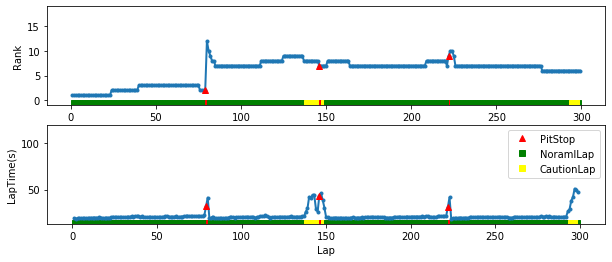

In [56]:
drawacar('Iowa-2018')

carno: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

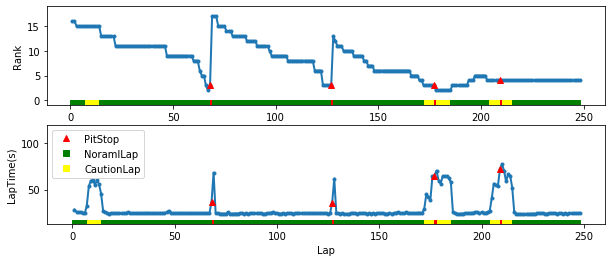

In [45]:
drawacar('Texas-2018', carno=5)

carno: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}
{1, 98,

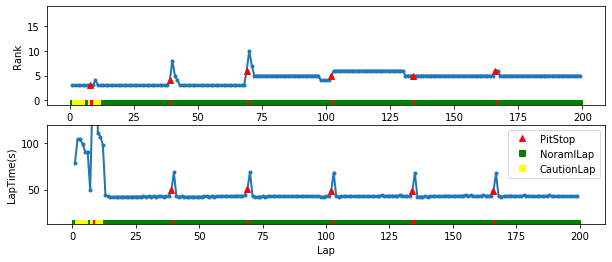

In [47]:
drawacar('Pocono-2018', carno=1)

carno: {1, 4, 5, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 

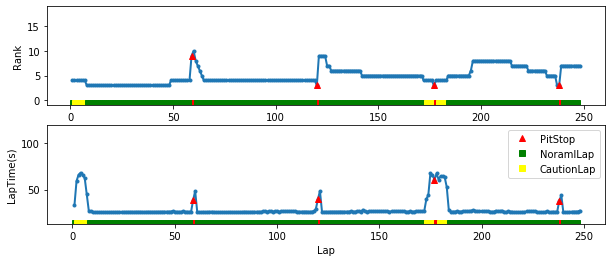

In [48]:
drawacar('Gateway-2018', carno=1)

carno: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201

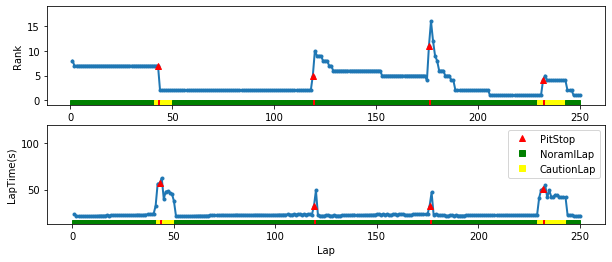

In [49]:
drawacar('Phoenix-2018', carno=1)

carno: {2, 4, 5, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

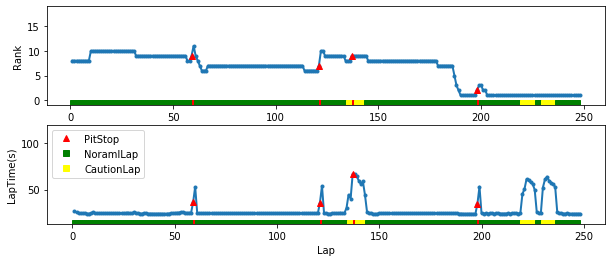

In [51]:
drawacar('Texas-2019', carno=2)

carno: {2, 3, 4, 5, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 39, 42, 48, 60, 63, 77, 81, 88, 98}
laps: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,

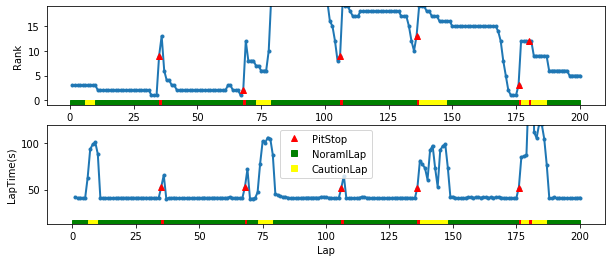

In [55]:
drawacar('Indy500-2019', carno=12)